# Import Library

In [1]:
import numpy as np
import os
import networkx as nx
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras import Sequential, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow_addons as tfa

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from layers import GraphConv
from models import GCN, DNN
from utils import (
    seed_everything, 
    limit_data, 
    encode_label, 
    normalize_Adj,
    draw_history,
    plot_tSNE,
)
import config as C

#### Set Seed

In [2]:
seed_everything(C.SEED)

# Cora Dataset 

In [3]:
all_data = []
all_edges = []

for root, dirs, files in os.walk(C.DATA_PATH):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root, file), 'r') as f:
                all_data.extend(f.read().splitlines())
        elif '.cites' in file:
            with open(os.path.join(root, file), 'r') as f:
                all_edges.extend(f.read().splitlines())

all_data = shuffle(all_data, random_state=C.SEED)

cora.content
1. Node ID
2. Node Feature
3. Node Label

cora.cites

(a, b)

a : ID of the paper being cited

b : the paper containing the citation

In [4]:
labels = []
nodes = []
X = []

for i, data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])
    
X = np.array(X, dtype=int)
N = X.shape[0]
F = X.shape[1]
print(f'LOG >>> X shape: {X.shape}')

LOG >>> X shape: (2708, 1433)


In [5]:
edge_list = []

for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0], e[1]))
    
print(f'LOG >>> Number of Nodes N : {N}')
print(f'LOG >>> Number of Features F of each node : {F}')
print(f'LOG >>> Categories :\n{set(labels)}')
# num_classes = len(set(labels))
print(f'LOG >>> Number of classes : {C.num_classes}')

LOG >>> Number of Nodes N : 2708
LOG >>> Number of Features F of each node : 1433
LOG >>> Categories :
{'Genetic_Algorithms', 'Rule_Learning', 'Probabilistic_Methods', 'Neural_Networks', 'Reinforcement_Learning', 'Theory', 'Case_Based'}
LOG >>> Number of classes : 7


In [6]:
len(edge_list)

5429

# Set Train, val and test mask 

In [7]:
train_idx, val_idx, test_idx = limit_data(labels)

In [8]:
print(f'LOG >>> Number of Train set : {len(train_idx)}')
print(f'LOG >>> Number of Valid set : {len(val_idx)}')
print(f'LOG >>> Number of Test set : {len(test_idx)}')

LOG >>> Number of Train set : 140
LOG >>> Number of Valid set : 500
LOG >>> Number of Test set : 1000


In [9]:
train_mask = np.zeros((N,), dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,), dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,), dtype=bool)
test_mask[test_idx] = True

### Get Adjacency Matrix, A 

In [10]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

A = nx.adjacency_matrix(G)
print(f'LOG >>> Graph info:\n{nx.info(G)}')

# Normalize A and convert type of X
A = normalize_Adj(A)
X = X.astype(np.float64)

LOG >>> Graph info:
Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


### Encode label with One-Hot

In [11]:
labels_encoded, classes = encode_label(labels)

# Raw Data 

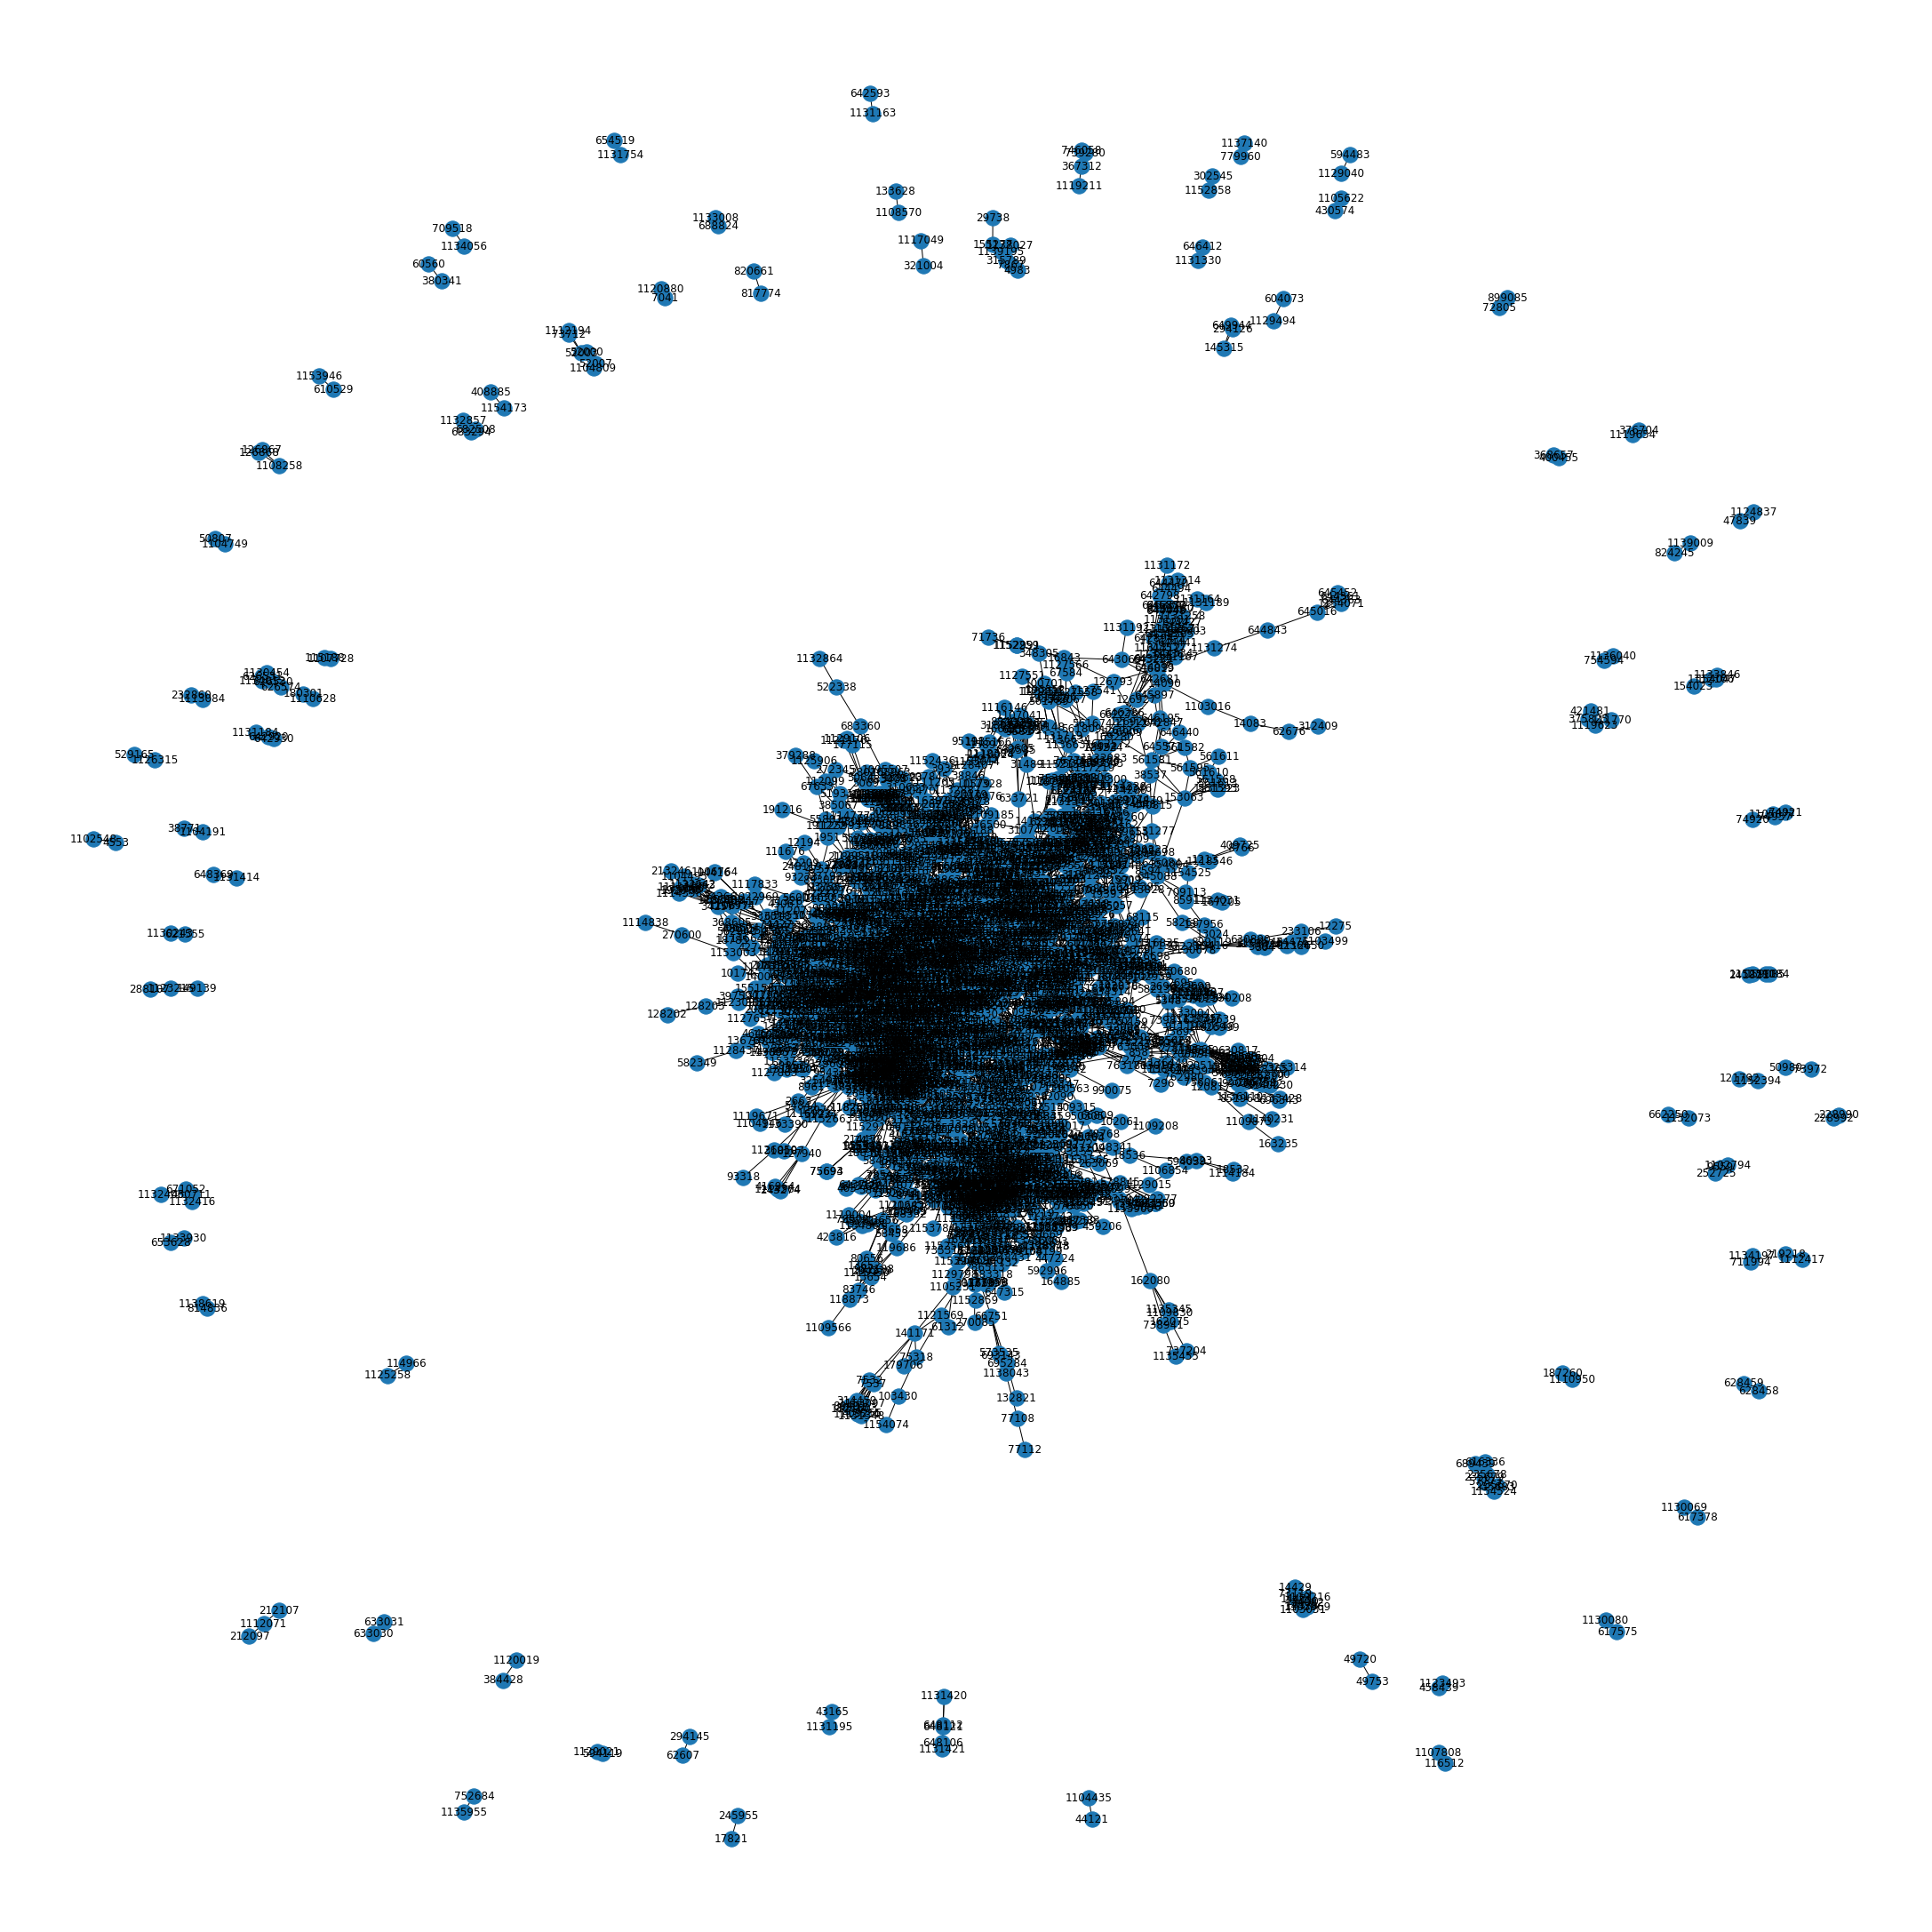

In [12]:
plt.figure(figsize=(30, 30))
nx.draw(G, with_labels=True)
plt.show()

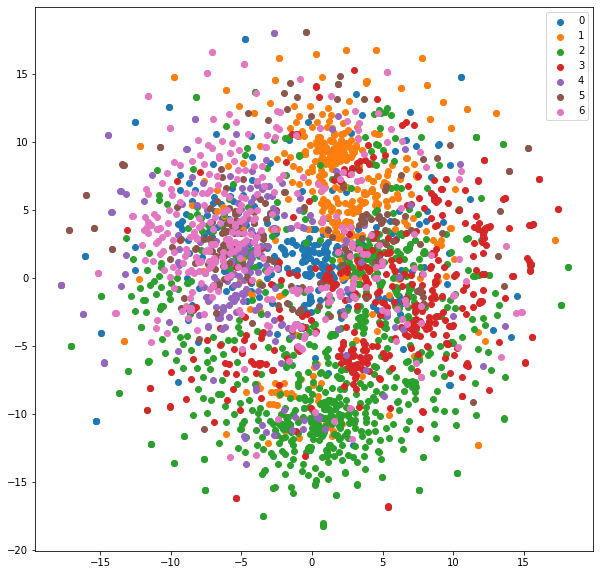

In [13]:
raw_x = TSNE(n_components=2).fit_transform(X)

plot_tSNE(labels_encoded, raw_x)

# DNN

#### Build Model 

In [14]:
DNN_model = DNN([128, 256], C.dropout)

DNN_model.compile(optimizer=Adam(1e-2),
           loss='categorical_crossentropy',
           weighted_metrics=['acc'])

#### Callbacks 

In [15]:
dnn_early_stop = EarlyStopping(patience=C.es_patience, restore_best_weights=True)

callbacks=[dnn_early_stop]

#### Make Valid data 

In [16]:
DNN_valid_data = (X, labels_encoded, val_mask)

#### Training 

Epoch 1/200
1/1 [==============================] - 1s 753ms/step - loss: 0.3035 - acc: 0.1357 - val_loss: 0.5046 - val_acc: 0.3100
Epoch 2/200
1/1 [==============================] - 0s 36ms/step - loss: 0.2463 - acc: 0.3429 - val_loss: 0.4615 - val_acc: 0.3580
Epoch 3/200
1/1 [==============================] - 0s 36ms/step - loss: 0.2017 - acc: 0.5643 - val_loss: 0.4281 - val_acc: 0.3780
Epoch 4/200
1/1 [==============================] - 0s 34ms/step - loss: 0.1687 - acc: 0.6000 - val_loss: 0.3973 - val_acc: 0.4520
Epoch 5/200
1/1 [==============================] - 0s 34ms/step - loss: 0.1384 - acc: 0.7429 - val_loss: 0.3661 - val_acc: 0.5120
Epoch 6/200
1/1 [==============================] - 0s 35ms/step - loss: 0.1136 - acc: 0.8429 - val_loss: 0.3345 - val_acc: 0.5300
Epoch 7/200
1/1 [==============================] - 0s 34ms/step - loss: 0.0919 - acc: 0.9143 - val_loss: 0.3087 - val_acc: 0.5640
Epoch 8/200
1/1 [==============================] - 0s 34ms/step - loss: 0.0799 - acc: 0.9

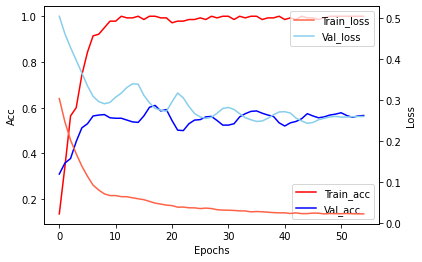

In [17]:
DNN_history = DNN_model.fit(X,
       labels_encoded,
       sample_weight=train_mask,
       epochs=C.epochs,
       batch_size=N,
       validation_data=DNN_valid_data,
       shuffle=False,
       callbacks=callbacks)

draw_history(DNN_history, 'DNN')

#### Evaluate 

In [18]:
X_te = X[test_mask]
y_te = labels_encoded[test_mask]

y_pred = DNN_model.predict(X_te, batch_size=N)

DNN_report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> DNN Classification Report:\n{DNN_report}')

LOG >>> DNN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.48      0.55      0.51       113
    Genetic_Algorithms       0.71      0.63      0.67       150
       Neural_Networks       0.64      0.58      0.61       306
 Probabilistic_Methods       0.55      0.54      0.54       167
Reinforcement_Learning       0.73      0.62      0.67        79
         Rule_Learning       0.29      0.65      0.40        62
                Theory       0.45      0.33      0.38       123

              accuracy                           0.55      1000
             macro avg       0.55      0.56      0.54      1000
          weighted avg       0.58      0.55      0.56      1000



#### Visualilzation 

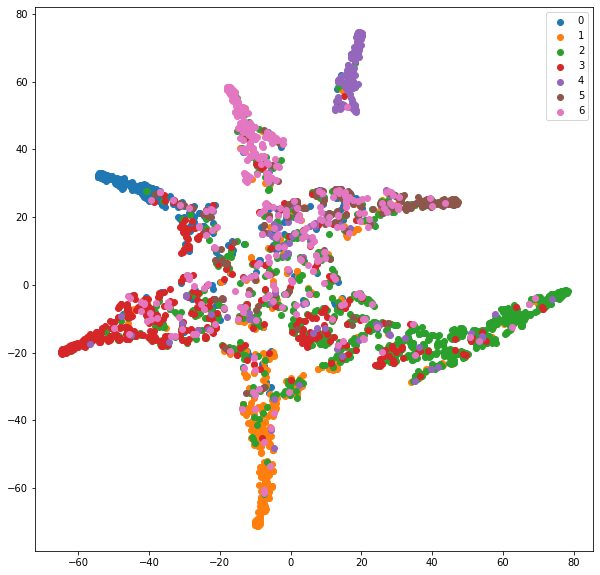

In [19]:
activations = DNN_model.predict(X)

dnn_x_tsne = TSNE(n_components=2).fit_transform(activations)
plot_tSNE(labels_encoded, dnn_x_tsne)

# DNN with metric learning

#### Build Model 

In [20]:
DNN_metric_model = DNN([128, 256], C.dropout)

DNN_metric_model.compile(optimizer=Adam(1e-2),
           loss=tfa.losses.TripletSemiHardLoss(),
            )

#### Callbacks

In [21]:
dnn_early_stop = EarlyStopping(patience=C.es_patience,
                               restore_best_weights=True,
                              monitor='loss')

callbacks=[dnn_early_stop]

#### Make Valid data

In [22]:
DNN_valid_data = (X, labels_encoded, val_mask)

#### Training

Epoch 1/200
1/1 [==============================] - 0s 73ms/step - loss: 0.0179 - acc: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0162 - acc: 0.0000e+00
Epoch 3/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0143 - acc: 0.0000e+00
Epoch 4/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0125 - acc: 0.0000e+00
Epoch 5/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0108 - acc: 0.0000e+00
Epoch 6/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0093 - acc: 0.0000e+00
Epoch 7/200
1/1 [==============================] - 0s 2ms/step - loss: 0.0080 - acc: 0.0000e+00
Epoch 8/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0068 - acc: 0.0000e+00
Epoch 9/200
1/1 [==============================] - 0s 1ms/step - loss: 0.0059 - acc: 0.0000e+00
Epoch 10/200
1/1 [==============================] - 0s 2ms/step - loss: 0.0051 - acc: 0.0000e+00
Epoch 11/200
1/1 [====================

1/1 [==============================] - 0s 2ms/step - loss: 3.3740e-06 - acc: 0.0000e+00
Epoch 82/200
1/1 [==============================] - 0s 1ms/step - loss: 3.0492e-06 - acc: 0.0000e+00
Epoch 83/200
1/1 [==============================] - 0s 2ms/step - loss: 2.7576e-06 - acc: 0.0000e+00
Epoch 84/200
1/1 [==============================] - 0s 2ms/step - loss: 2.4943e-06 - acc: 0.0000e+00
Epoch 85/200
1/1 [==============================] - 0s 3ms/step - loss: 2.2553e-06 - acc: 0.0000e+00
Epoch 86/200
1/1 [==============================] - 0s 2ms/step - loss: 2.0373e-06 - acc: 0.0000e+00
Epoch 87/200
1/1 [==============================] - 0s 2ms/step - loss: 1.8382e-06 - acc: 0.0000e+00
Epoch 88/200
1/1 [==============================] - 0s 2ms/step - loss: 1.6564e-06 - acc: 0.0000e+00
Epoch 89/200
1/1 [==============================] - 0s 1ms/step - loss: 1.4911e-06 - acc: 0.0000e+00
Epoch 90/200
1/1 [==============================] - 0s 1ms/step - loss: 1.3418e-06 - acc: 0.0000e+00
Epo

1/1 [==============================] - 0s 1ms/step - loss: 2.5057e-09 - acc: 0.0000e+00
Epoch 162/200
1/1 [==============================] - 0s 1ms/step - loss: 2.8465e-09 - acc: 0.0000e+00
Epoch 163/200
1/1 [==============================] - 0s 1ms/step - loss: 3.4516e-09 - acc: 0.0000e+00
Epoch 164/200
1/1 [==============================] - 0s 1ms/step - loss: 3.6122e-09 - acc: 0.0000e+00
Epoch 165/200
1/1 [==============================] - 0s 1ms/step - loss: 3.1358e-09 - acc: 0.0000e+00
Epoch 166/200
1/1 [==============================] - 0s 2ms/step - loss: 2.5716e-09 - acc: 0.0000e+00
Epoch 167/200
1/1 [==============================] - 0s 2ms/step - loss: 2.4335e-09 - acc: 0.0000e+00
Epoch 168/200
1/1 [==============================] - 0s 2ms/step - loss: 2.6407e-09 - acc: 0.0000e+00
Epoch 169/200
1/1 [==============================] - 0s 1ms/step - loss: 2.7103e-09 - acc: 0.0000e+00
Epoch 170/200
1/1 [==============================] - 0s 1ms/step - loss: 2.5157e-09 - acc: 0.000

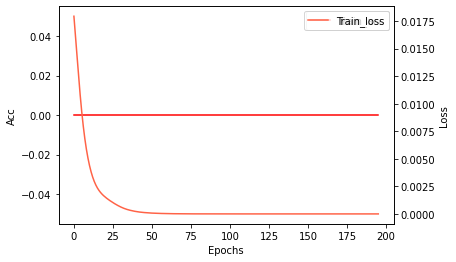

In [23]:
DNN_metric_history = DNN_model.fit(X[train_mask],
       epochs=C.epochs,
       batch_size=N,
       shuffle=False,
       callbacks=callbacks)

draw_history(DNN_metric_history, 'DNN_Metric')

#### Evaluate 

In [24]:
X_te = X[test_mask]
y_te = labels_encoded[test_mask]

y_pred = DNN_metric_model.predict(X_te, batch_size=N)

DNN_metric_report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> DNN Metric Classification Report:\n{DNN_metric_report}')

LOG >>> DNN Metric Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.10      0.03      0.04       113
    Genetic_Algorithms       0.19      0.19      0.19       150
       Neural_Networks       0.24      0.08      0.12       306
 Probabilistic_Methods       0.16      0.44      0.23       167
Reinforcement_Learning       0.02      0.03      0.02        79
         Rule_Learning       0.08      0.03      0.05        62
                Theory       0.08      0.09      0.08       123

              accuracy                           0.14      1000
             macro avg       0.12      0.13      0.10      1000
          weighted avg       0.16      0.14      0.12      1000



#### Visualization

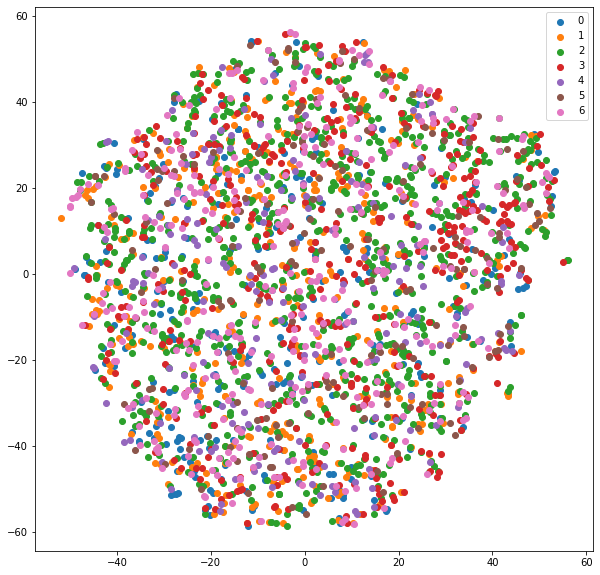

In [25]:
activations = DNN_metric_model.predict(X)

dnn_metric_x_tsne = TSNE(n_components=2).fit_transform(activations)
plot_tSNE(labels_encoded, dnn_metric_x_tsne)

# GCN

#### Build Model 

In [26]:
model = GCN(C.GCN_filters, C.dropout)

optimizer = Adam(lr=C.learning_rate)
model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             weighted_metrics=['acc'])

#### Callbacks

In [27]:
# tensorboard = tf.keras.callbacks.TensorBoard(log_dir=C.LOG_PATH)
early_stop = tf.keras.callbacks.EarlyStopping(patience=C.es_patience, restore_best_weights=True)

# callbacks = [tensorboard, early_stop]
callbacks = [early_stop]

#### Make Valid data 

In [28]:
validation_data = ([A, X], labels_encoded, val_mask)

#### Training 

Epoch 1/200
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 1433])]
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 16])]
1/1 [==============================] - 1s 665ms/step - loss: 0.1212 - acc: 0.1429 - val_loss: 0.3712 - val_acc: 0.2440
Epoch 2/200
1/1 [==============================] - 0s 110ms/step - loss: 0.1130 - acc: 0.3214 - val_loss: 0.3605 - val_acc: 0.3100
Epoch 3/200
1/1 [==============================] - 0s 105ms/step - loss: 0.1054 - acc: 0.4929 - val_loss: 0.3502 - val_acc: 0.3720
Epoch 4/200
1/1 [==============================] - 0s 106ms/step - loss: 0.1009 - acc: 0.5071 - val_loss: 0.3399 - val_acc: 0.4400
Epoch 5/200
1/1 [==============================] - 0s 109ms/step - loss: 0.0950 - acc: 0.6357 - val_loss: 0.3304 - val_acc: 0.4840
Epoch 6/200
1/1 [==============================] - 0s 109ms/step - loss: 0.0918 - acc: 0.6571 - val_loss: 0.3209 - val_acc: 0.5220
Epoch 7/200
1/1 [==============================] - 0s 105ms/step

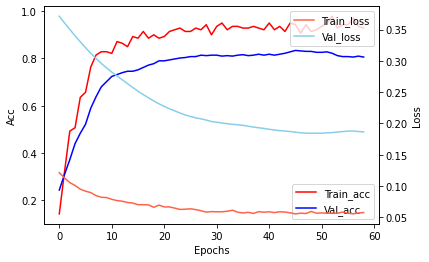

In [29]:
history = model.fit([A, X],
         labels_encoded,
         sample_weight=train_mask,
         epochs=C.epochs,
         batch_size=N,
         validation_data=validation_data,
         shuffle=False,
         callbacks=callbacks)

draw_history(history, 'GCN')

#### Evaluate 

In [30]:
X_te = X[test_mask]
A_te = A[test_mask, :][:, test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([A_te, X_te], batch_size=N)
report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> GCN Classification Report:\n{report}')

LOG >>> GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.77      0.72      0.74       113
    Genetic_Algorithms       0.85      0.81      0.83       150
       Neural_Networks       0.85      0.75      0.80       306
 Probabilistic_Methods       0.82      0.81      0.81       167
Reinforcement_Learning       0.76      0.78      0.77        79
         Rule_Learning       0.53      0.79      0.64        62
                Theory       0.56      0.65      0.60       123

              accuracy                           0.76      1000
             macro avg       0.73      0.76      0.74      1000
          weighted avg       0.77      0.76      0.76      1000



####  Visualization

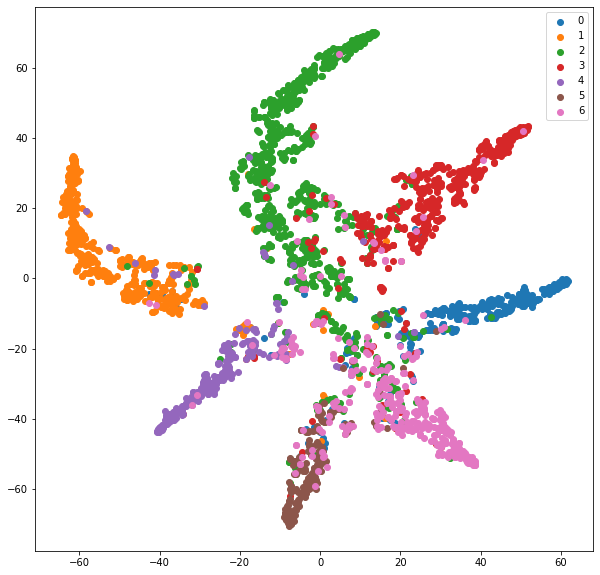

In [31]:
activations = model.predict([A, X], batch_size=N)

x_tsne = TSNE(n_components=2).fit_transform(activations)

plot_tSNE(labels_encoded, x_tsne)

# Skip Connection

In [ ]:
class SkipConnection(tf.keras.layers.Layer):
    def __init__(self, in_dim, filters):
        super(SkipConnection, self).__init__()
        self.in_dim = in_dim
        self.filters = filters
        self.gcn = GraphConv(self.filters,
                             use_bias=False,
                             kernel_regularizer=tf.keras.regularizers.l2(C.l2_reg))
    def call(self, input_tensor, training=False):
        A, x = input_tensor
        if self.in_dim != self.filters:
            
        f = self.gcn([A, x])
        
        return 

# Inception GCN

In [81]:
class InceptionBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(InceptionBlock, self).__init__()

        self.gcn1 = GraphConv(filters,
                                    use_bias=False,
                                    kernel_regularizer=tf.keras.regularizers.l2(C.l2_reg))
        
        self.gcn2_1 = GraphConv(filters,
                                    use_bias=False,
                                    kernel_regularizer=tf.keras.regularizers.l2(C.l2_reg))
        self.gcn2_2 = GraphConv(filters,
                                    use_bias=False,
                                    kernel_regularizer=tf.keras.regularizers.l2(C.l2_reg))

        self.gcn3_1 = GraphConv(filters,
                                    use_bias=False,
                                    kernel_regularizer=tf.keras.regularizers.l2(C.l2_reg))
        self.gcn3_2 = GraphConv(filters,
                                    use_bias=False,
                                    kernel_regularizer=tf.keras.regularizers.l2(C.l2_reg))
        self.gcn3_3 = GraphConv(filters,
                                    use_bias=False,
                                    kernel_regularizer=tf.keras.regularizers.l2(C.l2_reg))

        self.average = tf.keras.layers.Average()

    def call(self, input_tensor, training=False):
        tf.print(input_tensor[1])
        A, x = input_tensor
        A, f1 = self.gcn1([A, x])

        A, f2 = self.gcn2_1([A, x])
        A, f2 = self.gcn2_2([A, f2])

        A, f3 = self.gcn3_1([A, x])
        A, f3 = self.gcn3_2([A, f3])
        A, f3 = self.gcn3_3([A, f3])
        
        output = self.average([f1, f2, f3])        
        # tf.print(output)
        return output

In [82]:
class InceptionGCN(tf.keras.Model):
    def __init__(self, filters, dropout):
        super(InceptionGCN, self).__init__(name='Inception_GCN')
        self.dropout_1 = Dropout(C.dropout)
        self.inception_1 = InceptionBlock(C.GCN_filters)
        self.dropout_2 = Dropout(C.dropout)
        self.inception_2 = InceptionBlock(C.num_classes)

    def call(self, input_tensor, training=False):
        A, x = input_tensor
        x = self.dropout_1(x)
        x = self.inception_1([A, x])
        x = self.dropout_2(x)
        x = self.inception_2([A, x])
        return x

#### Build Model

In [83]:
inception_GCN_model = InceptionGCN(C.GCN_filters, C.dropout)

optimizer = Adam(lr=C.learning_rate)
inception_GCN_model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             weighted_metrics=['acc'])

#### Training

In [84]:
history = inception_GCN_model.fit([A, X],
         labels_encoded,
         sample_weight=train_mask,
         epochs=C.epochs,
         batch_size=N,
         validation_data=validation_data,
         shuffle=False,
         callbacks=callbacks)

draw_history(history, 'Inception GCN')

Epoch 1/200
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 1433])]
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 1433])]
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 16])]
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 1433])]
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 16])]
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 16])]
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 16])]
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 16])]
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 7])]
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 16])]
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 7])]
LOG >>> input shape: [TensorShape([2708, 2708]), TensorShape([2708, 7])]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 

[[-nan -nan -nan ... -nan -nan -nan]
 [-nan -nan -nan ... -nan -nan -nan]
 [-nan -nan -nan ... -nan -nan -nan]
 ...
 [-nan -nan -nan ... -nan -nan -nan]
 [-nan -nan -nan ... -nan -nan -nan]
 [-nan -nan -nan ... -nan -nan -nan]]
1/1 [==============================] - ETA: 0s - loss: nan - acc: 0.1429[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[-nan -nan -nan ... -nan -nan -nan]
 [-nan -nan -nan ... -nan -nan -nan]
 [-nan -nan -nan ... -nan -nan -nan]
 ...
 [-nan -nan -nan ... -nan -nan -nan]
 [-nan -nan -nan ... -nan -nan -nan]
 [-nan -nan -nan ... -nan -nan -nan]]
1/1 [==============================] - 0s 136ms/step - loss: nan - acc: 0.1429 - val_loss: nan - val_acc: 0.1100
Epoch 10/200
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[-nan -nan -nan ... -nan -nan -nan]
 [-nan -nan -nan ... -nan -nan -nan]
 [-nan -nan -nan ... -nan -nan -

TypeError: object of type 'NoneType' has no len()

#### Evaluate

In [ ]:
X_te = X[test_mask]
A_te = A[test_mask, :][:, test_mask]
y_te = labels_encoded[test_mask]

y_pred = inception_GCN_model.predict([A_te, X_te], batch_size=N)
report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> Inception GCN Classification Report:\n{report}')

#### Visualization

In [ ]:
activations = inception_GCN_model.predict([A, X], batch_size=N)

x_tsne = TSNE(n_components=2).fit_transform(activations)

plot_tSNE(labels_encoded, x_tsne)